# EEG-Based Gesture Classification using Deep Learning

This notebook implements and compares three deep learning approaches for classifying gestures from EEG signals.

EEG signals measure electrical activity in the brain, allowing for gesture recognition through machine learning. This has applications in brain-computer interfaces, neurofeedback, and assistive technologies.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import time
from tqdm import tqdm


In [18]:

# Load the dataset from a CSV file.
df = pd.read_csv("data/processed/EEG-data.csv")


# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Helper Functions
def print_color(text: str, color: str) -> None:
    """
    Prints text in specified ANSI color for better readability.
    
    Args:
        text (str): Text to be printed
        color (str): Color name ('red', 'green', 'yellow', 'blue', 'magenta')
    """
    colors = {
        "red": "\033[91m",
        "green": "\033[92m",
        "yellow": "\033[93m",
        "blue": "\033[94m",
        "magenta": "\033[95m"
    }
    print(f"{colors.get(color, '')}{text}\033[0m")


In [20]:

# Adjust gesture labels to be zero-indexed
df['gesture'] = df['gesture'] - 1

# Count number of unique gestures
num_classes = df['gesture'].nunique()

# Display initial data and dataset structure
print_color("Head of DataFrame:", "green")
print(df.head())
print_color("Shape of DataFrame:", "green")
print(df.shape)

# Check and display any null values in the dataset
null_count = df.isnull().sum()
print_color("Null values in each column:", "yellow")
print(null_count)

# List and display unique gestures and subjects
print_color("Unique gestures (after adjustment to 0-index):", "blue")
print(sorted(df["gesture"].unique()))
print_color("Unique subjects:", "blue")
print(sorted(df["subject"].unique()))


Head of DataFrame:
      Channel_1     Channel_2     Channel_3     Channel_4     Channel_5  \
0  11799.284732  25973.866996   8188.203953 -10663.927873 -35497.006535   
1  11972.242531  25453.406626   8654.461343 -10467.009004 -35550.494260   
2  12159.527798  28133.336083  11770.026299 -10468.461867 -35849.918228   
3  12017.124834  29031.965617  11734.889356 -10659.748096 -35842.810374   
4  11815.936782  26442.828946   8583.606313 -10681.473992 -35537.530248   

     Channel_6     Channel_7    Channel_8  subject  repetition  gesture  
0  3438.838236  26879.157350  9470.367070        1           1        0  
1  3470.309492  26851.307076  9466.455515        1           1        0  
2  3275.894019  26572.066733  9239.048867        1           1        0  
3  3213.420893  26560.130901  9208.002294        1           1        0  
4  3404.304791  26842.925172  9432.570271        1           1        0  
Shape of DataFrame:
(564641, 11)
Null values in each column:
Channel_1     0
Channel_2

In [21]:

# Windowing Setup
# Set window size and step size for slicing the data
WINDOW_SIZE = 100  # Number of samples per window
STEP_SIZE = 50     # Interval at which new windows are created

# Initialize lists to store windowed data and corresponding labels
X_list = []
y_list = []

# Group the data by gesture, extracting features for each gesture
for gesture_id in sorted(df["gesture"].unique()):
    gesture_df = df[df["gesture"] == gesture_id]
    gesture_data = gesture_df[
        ["Channel_1", "Channel_2", "Channel_3", "Channel_4",
         "Channel_5", "Channel_6", "Channel_7", "Channel_8"]
    ].values  # Extract channel data as numpy array

    # Generate overlapping windows of data
    for start_idx in range(0, len(gesture_data) - WINDOW_SIZE + 1, STEP_SIZE):
        window_data = gesture_data[start_idx:start_idx + WINDOW_SIZE]
        X_list.append(window_data)
        y_list.append(gesture_id)

# Convert lists to numpy arrays
X_array = np.array(X_list)
y_array = np.array(y_list)


# Display shapes of the prepared datasets
print_color("Shape of X_array:", "red")
print(X_array.shape)
print_color("Shape of y_array:", "red")
print(y_array.shape)

# Print statistics about the data
print_color("Data statistics in X_array:", "green")
print("Mean:", np.mean(X_array, axis=(0, 1)))
print("Standard Deviation:", np.std(X_array, axis=(0, 1)))
print("Max value:", np.max(X_array))
print("Min value:", np.min(X_array))


Shape of X_array:
(11284, 100, 8)
Shape of y_array:
(11284,)
Data statistics in X_array:
Mean: [ 30244.89846683  15608.61800047 -27604.40113342 -36218.57062948
  -5589.92723282   4045.19480258   4957.55115371   -192.39088865]
Standard Deviation: [27032.89760666 26150.03950825 58529.99615017 64556.72894489
 31995.9402765  30144.2309942  28369.17064876 26826.76880783]
Max value: 97585.54817265848
Min value: -187500.02235174447


In [22]:

# Normalize the data
X_mean = np.mean(X_array)
X_std = np.std(X_array)
X_array = (X_array - X_mean) / X_std

# Convert to PyTorch tensors and move to device
X_tensor = torch.FloatTensor(X_array).to(device)
y_tensor = torch.LongTensor(y_array).to(device)

# Print statistics about the tensor data
print_color("Shape of X_tensor:", "red")
print(X_tensor.shape)
print_color("Shape of y_tensor:", "red")
print(y_tensor.shape)
print_color("Data statistics in X_tensor:", "green")
print(f"Mean: {X_tensor.mean().item():.4f}")
print(f"Standard Deviation: {X_tensor.std().item():.4f}")
print(f"Max value: {X_tensor.max().item():.4f}")
print(f"Min value: {X_tensor.min().item():.4f}")

Shape of X_tensor:
torch.Size([11284, 100, 8])
Shape of y_tensor:
torch.Size([11284])
Data statistics in X_tensor:
Mean: 0.0000
Standard Deviation: 1.0000
Max value: 2.2414
Min value: -4.1853


In [23]:

# Split data into train, validation, test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=RANDOM_SEED, stratify=y_tensor.cpu()
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train.cpu()
)

print_color(f"Train set: {X_train.shape[0]} samples", "green")
print_color(f"Validation set: {X_val.shape[0]} samples", "green")
print_color(f"Test set: {X_test.shape[0]} samples", "green")
    

Train set: 7221 samples
Validation set: 1806 samples
Test set: 2257 samples


In [24]:
class CNN1D(nn.Module):
    def __init__(self, win_size: int, num_channels: int, num_classes: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),  # Increased filters
            nn.BatchNorm1d(128),  # Added batch norm
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # Added extra layer
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(256, 512, kernel_size=3, padding=1),  # Deeper architecture
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Better than fixed pooling
            
            nn.Flatten(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Permute to (batch_size, channels, time_steps)
        x = x.permute(0, 2, 1)
        return self.model(x)


class LSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(LSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size=num_channels, hidden_size=64, batch_first=True, bidirectional=False)
        self.drop1 = nn.Dropout(0.2)  # Apply dropout after first LSTM
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=False)
        self.drop2 = nn.Dropout(0.2)  # Apply dropout after second LSTM

        self.fc1 = nn.Linear(64, 128)
        self.drop_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.drop1(x)
        x, _ = self.lstm2(x)
        x = self.drop2(x)

        x = x[:, -1, :]  # Take only the last time step output
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        x = self.fc2(x)

        return x


class CNNLSTMModel(nn.Module):
    def __init__(self, win_size, num_channels, num_classes):
        super(CNNLSTMModel, self).__init__()
       
        # --- CNN Block ---
        self.cnn_block = nn.Sequential(
            nn.Conv1d(num_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
           
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3),
        )
       
        # --- Attention Layer ---
        self.attention = nn.Sequential(
            nn.Conv1d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )
       
        # --- LSTM Block (Fixed Dropout) ---
        self.lstm1 = nn.LSTM(
            input_size=256,
            hidden_size=128,
            batch_first=True,
            bidirectional=True,
            dropout=0  # Fixed: Set to 0 for a single-layer LSTM
        )
       
        self.lstm2 = nn.LSTM(
            input_size=256,  # 128*2 due to bidirectional
            hidden_size=128,
            batch_first=True,
            bidirectional=True,
            dropout=0  # Fixed: Set to 0 for a single-layer LSTM
        )
       
        # --- Fully Connected Layers ---
        self.fc_block = nn.Sequential(
            nn.Linear(256, 512),  # 128*2 due to bidirectional
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
       
    def forward(self, x):
        # Reshape input for CNN: (batch_size, channels, time_steps)
        x = x.permute(0, 2, 1)
           
        # CNN feature extraction
        cnn_features = self.cnn_block(x)
       
        # Apply attention to CNN features
        attention_weights = self.attention(cnn_features)
        attended_features = cnn_features * attention_weights
       
        # Reshape for LSTM: (batch, time, features)
        lstm_input = attended_features.permute(0, 2, 1)
       
        # LSTM processing
        lstm_out1, _ = self.lstm1(lstm_input)
        lstm_out2, _ = self.lstm2(lstm_out1)
       
        # Global context representation (max + avg pooling)
        max_pool = torch.max(lstm_out2, dim=1)[0]
        avg_pool = torch.mean(lstm_out2, dim=1)
        combined_features = max_pool + avg_pool
       
        # Final classification
        output = self.fc_block(combined_features)
       
        return output
   
    def initialize_weights(self):
        """Initialize model weights for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)



In [25]:

# Training and Evaluation Functions
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
               criterion: nn.Module, optimizer: torch.optim.Optimizer, 
               device: torch.device, epochs: int = 10) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Train a model using the provided data loader.
    
    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer for updating model weights
        device: Device to perform computations on (CPU/GPU)
        epochs: Number of training epochs
    
    Returns:
        Tuple of (train_losses, val_losses, train_accs, val_accs)
    """
    model.train()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss/total, 
                'acc': 100.*correct/total
            })
        
        # Training epoch statistics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        # Validation epoch statistics
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    
    return train_losses, val_losses, train_accs, val_accs


In [26]:
# Training settings
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [27]:

    
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)



# Loss function with class weights if needed
criterion = nn.CrossEntropyLoss()

# Create directory for models
os.makedirs("models", exist_ok=True)

all_metrics = {}


In [28]:

# Train CNN model
print_color("\nTraining CNN Model...", "magenta")
cnn_model = CNN1D(win_size=100, num_channels=8, num_classes=num_classes).to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(
        cnn_model, train_loader, val_loader, criterion, cnn_optimizer, device, EPOCHS
    )
cnn_train_time = time.time() - start_time

all_metrics['CNN'] = {
      'train_loss': cnn_train_losses,
      'val_loss': cnn_val_losses,
      'train_acc': cnn_train_accs,
      'val_acc': cnn_val_accs
  }

print(f"CNN training completed in {cnn_train_time:.2f} seconds")


Training CNN Model...


Epoch 1/100: 100%|██████████| 113/113 [00:01<00:00, 67.02it/s, loss=1.32, acc=44.9]


Epoch 1/100, Train Loss: 1.3233, Train Acc: 44.94%, Val Loss: 1.0316, Val Acc: 55.81%


Epoch 2/100: 100%|██████████| 113/113 [00:01<00:00, 108.14it/s, loss=1.02, acc=56.4]


Epoch 2/100, Train Loss: 1.0176, Train Acc: 56.39%, Val Loss: 0.9110, Val Acc: 57.86%


Epoch 3/100: 100%|██████████| 113/113 [00:01<00:00, 97.33it/s, loss=0.915, acc=60.4] 


Epoch 3/100, Train Loss: 0.9152, Train Acc: 60.38%, Val Loss: 0.8791, Val Acc: 61.07%


Epoch 4/100: 100%|██████████| 113/113 [00:01<00:00, 104.92it/s, loss=0.86, acc=63]   


Epoch 4/100, Train Loss: 0.8604, Train Acc: 63.04%, Val Loss: 0.6955, Val Acc: 74.86%


Epoch 5/100: 100%|██████████| 113/113 [00:01<00:00, 105.21it/s, loss=0.779, acc=66.9]


Epoch 5/100, Train Loss: 0.7794, Train Acc: 66.93%, Val Loss: 0.8511, Val Acc: 63.90%


Epoch 6/100: 100%|██████████| 113/113 [00:01<00:00, 99.92it/s, loss=0.76, acc=67.2]  


Epoch 6/100, Train Loss: 0.7604, Train Acc: 67.25%, Val Loss: 0.6346, Val Acc: 73.92%


Epoch 7/100: 100%|██████████| 113/113 [00:01<00:00, 99.64it/s, loss=0.71, acc=69.4] 


Epoch 7/100, Train Loss: 0.7103, Train Acc: 69.42%, Val Loss: 0.5816, Val Acc: 76.30%


Epoch 8/100: 100%|██████████| 113/113 [00:01<00:00, 94.25it/s, loss=0.698, acc=69.7]


Epoch 8/100, Train Loss: 0.6977, Train Acc: 69.73%, Val Loss: 0.5221, Val Acc: 78.02%


Epoch 9/100: 100%|██████████| 113/113 [00:01<00:00, 102.91it/s, loss=0.643, acc=73]  


Epoch 9/100, Train Loss: 0.6430, Train Acc: 73.02%, Val Loss: 0.4807, Val Acc: 79.90%


Epoch 10/100: 100%|██████████| 113/113 [00:01<00:00, 104.83it/s, loss=0.632, acc=72.5]


Epoch 10/100, Train Loss: 0.6317, Train Acc: 72.48%, Val Loss: 0.5542, Val Acc: 80.29%


Epoch 11/100: 100%|██████████| 113/113 [00:01<00:00, 105.22it/s, loss=0.607, acc=74]  


Epoch 11/100, Train Loss: 0.6072, Train Acc: 74.01%, Val Loss: 0.5551, Val Acc: 75.08%


Epoch 12/100: 100%|██████████| 113/113 [00:01<00:00, 104.25it/s, loss=0.594, acc=74.6]


Epoch 12/100, Train Loss: 0.5936, Train Acc: 74.64%, Val Loss: 0.6407, Val Acc: 73.09%


Epoch 13/100: 100%|██████████| 113/113 [00:01<00:00, 100.89it/s, loss=0.559, acc=76.1]


Epoch 13/100, Train Loss: 0.5587, Train Acc: 76.10%, Val Loss: 0.5218, Val Acc: 79.51%


Epoch 14/100: 100%|██████████| 113/113 [00:01<00:00, 95.76it/s, loss=0.516, acc=78.2]


Epoch 14/100, Train Loss: 0.5161, Train Acc: 78.17%, Val Loss: 0.5598, Val Acc: 73.42%


Epoch 15/100: 100%|██████████| 113/113 [00:01<00:00, 112.10it/s, loss=0.47, acc=80]   


Epoch 15/100, Train Loss: 0.4701, Train Acc: 79.96%, Val Loss: 0.4486, Val Acc: 82.23%


Epoch 16/100: 100%|██████████| 113/113 [00:01<00:00, 112.43it/s, loss=0.5, acc=78.8]  


Epoch 16/100, Train Loss: 0.5000, Train Acc: 78.77%, Val Loss: 0.4184, Val Acc: 84.00%


Epoch 17/100: 100%|██████████| 113/113 [00:01<00:00, 106.61it/s, loss=0.504, acc=78.9]


Epoch 17/100, Train Loss: 0.5043, Train Acc: 78.89%, Val Loss: 0.4122, Val Acc: 82.95%


Epoch 18/100: 100%|██████████| 113/113 [00:01<00:00, 103.10it/s, loss=0.469, acc=79.7]


Epoch 18/100, Train Loss: 0.4689, Train Acc: 79.73%, Val Loss: 0.3378, Val Acc: 86.27%


Epoch 19/100: 100%|██████████| 113/113 [00:01<00:00, 101.71it/s, loss=0.463, acc=80.1]


Epoch 19/100, Train Loss: 0.4632, Train Acc: 80.11%, Val Loss: 0.4098, Val Acc: 79.79%


Epoch 20/100: 100%|██████████| 113/113 [00:01<00:00, 100.09it/s, loss=0.437, acc=81]  


Epoch 20/100, Train Loss: 0.4366, Train Acc: 81.04%, Val Loss: 0.3386, Val Acc: 85.60%


Epoch 21/100: 100%|██████████| 113/113 [00:01<00:00, 99.04it/s, loss=0.482, acc=79.5] 


Epoch 21/100, Train Loss: 0.4823, Train Acc: 79.48%, Val Loss: 0.3280, Val Acc: 88.43%


Epoch 22/100: 100%|██████████| 113/113 [00:01<00:00, 108.97it/s, loss=0.433, acc=81.7]


Epoch 22/100, Train Loss: 0.4333, Train Acc: 81.71%, Val Loss: 0.4213, Val Acc: 80.01%


Epoch 23/100: 100%|██████████| 113/113 [00:01<00:00, 104.92it/s, loss=0.454, acc=80.9]


Epoch 23/100, Train Loss: 0.4542, Train Acc: 80.94%, Val Loss: 0.3443, Val Acc: 85.38%


Epoch 24/100: 100%|██████████| 113/113 [00:01<00:00, 104.44it/s, loss=0.431, acc=81.5]


Epoch 24/100, Train Loss: 0.4313, Train Acc: 81.47%, Val Loss: 0.3159, Val Acc: 85.27%


Epoch 25/100: 100%|██████████| 113/113 [00:01<00:00, 104.15it/s, loss=0.406, acc=82.8]


Epoch 25/100, Train Loss: 0.4058, Train Acc: 82.76%, Val Loss: 0.2861, Val Acc: 89.59%


Epoch 26/100: 100%|██████████| 113/113 [00:01<00:00, 101.62it/s, loss=0.414, acc=82.5]


Epoch 26/100, Train Loss: 0.4140, Train Acc: 82.51%, Val Loss: 0.3024, Val Acc: 89.53%


Epoch 27/100: 100%|██████████| 113/113 [00:01<00:00, 100.00it/s, loss=0.392, acc=82.9]


Epoch 27/100, Train Loss: 0.3922, Train Acc: 82.91%, Val Loss: 0.3156, Val Acc: 88.93%


Epoch 28/100: 100%|██████████| 113/113 [00:01<00:00, 107.42it/s, loss=0.389, acc=83.3]


Epoch 28/100, Train Loss: 0.3885, Train Acc: 83.33%, Val Loss: 0.2693, Val Acc: 90.81%


Epoch 29/100: 100%|██████████| 113/113 [00:01<00:00, 103.86it/s, loss=0.377, acc=83.6]


Epoch 29/100, Train Loss: 0.3773, Train Acc: 83.60%, Val Loss: 0.2491, Val Acc: 91.64%


Epoch 30/100: 100%|██████████| 113/113 [00:01<00:00, 101.90it/s, loss=0.357, acc=84.8]


Epoch 30/100, Train Loss: 0.3567, Train Acc: 84.84%, Val Loss: 0.3112, Val Acc: 85.66%


Epoch 31/100: 100%|██████████| 113/113 [00:01<00:00, 103.00it/s, loss=0.382, acc=83.6]


Epoch 31/100, Train Loss: 0.3817, Train Acc: 83.60%, Val Loss: 0.2428, Val Acc: 92.47%


Epoch 32/100: 100%|██████████| 113/113 [00:01<00:00, 101.26it/s, loss=0.375, acc=84.2]


Epoch 32/100, Train Loss: 0.3745, Train Acc: 84.20%, Val Loss: 0.3439, Val Acc: 83.17%


Epoch 33/100: 100%|██████████| 113/113 [00:01<00:00, 100.72it/s, loss=0.349, acc=84.5]


Epoch 33/100, Train Loss: 0.3488, Train Acc: 84.52%, Val Loss: 0.2613, Val Acc: 87.26%


Epoch 34/100: 100%|██████████| 113/113 [00:01<00:00, 105.61it/s, loss=0.357, acc=84.8]


Epoch 34/100, Train Loss: 0.3574, Train Acc: 84.75%, Val Loss: 0.2554, Val Acc: 89.20%


Epoch 35/100: 100%|██████████| 113/113 [00:01<00:00, 105.91it/s, loss=0.337, acc=85.4]


Epoch 35/100, Train Loss: 0.3368, Train Acc: 85.42%, Val Loss: 0.2233, Val Acc: 91.25%


Epoch 36/100: 100%|██████████| 113/113 [00:01<00:00, 100.36it/s, loss=0.333, acc=85.6]


Epoch 36/100, Train Loss: 0.3325, Train Acc: 85.58%, Val Loss: 0.2811, Val Acc: 87.49%


Epoch 37/100: 100%|██████████| 113/113 [00:01<00:00, 103.76it/s, loss=0.32, acc=86.2] 


Epoch 37/100, Train Loss: 0.3197, Train Acc: 86.19%, Val Loss: 0.2134, Val Acc: 94.41%


Epoch 38/100: 100%|██████████| 113/113 [00:01<00:00, 102.82it/s, loss=0.356, acc=84.6]


Epoch 38/100, Train Loss: 0.3559, Train Acc: 84.64%, Val Loss: 0.2716, Val Acc: 88.48%


Epoch 39/100: 100%|██████████| 113/113 [00:01<00:00, 99.21it/s, loss=0.348, acc=85.1] 


Epoch 39/100, Train Loss: 0.3481, Train Acc: 85.07%, Val Loss: 0.2062, Val Acc: 94.24%


Epoch 40/100: 100%|██████████| 113/113 [00:01<00:00, 108.24it/s, loss=0.345, acc=85.4]


Epoch 40/100, Train Loss: 0.3450, Train Acc: 85.40%, Val Loss: 0.2481, Val Acc: 90.59%


Epoch 41/100: 100%|██████████| 113/113 [00:01<00:00, 106.20it/s, loss=0.311, acc=87] 


Epoch 41/100, Train Loss: 0.3105, Train Acc: 86.98%, Val Loss: 0.2965, Val Acc: 86.77%


Epoch 42/100: 100%|██████████| 113/113 [00:01<00:00, 101.80it/s, loss=0.343, acc=85.7]


Epoch 42/100, Train Loss: 0.3434, Train Acc: 85.74%, Val Loss: 0.2281, Val Acc: 90.42%


Epoch 43/100: 100%|██████████| 113/113 [00:01<00:00, 98.35it/s, loss=0.297, acc=87.7]


Epoch 43/100, Train Loss: 0.2973, Train Acc: 87.66%, Val Loss: 0.3453, Val Acc: 84.72%


Epoch 44/100: 100%|██████████| 113/113 [00:01<00:00, 102.45it/s, loss=0.291, acc=87.5]


Epoch 44/100, Train Loss: 0.2913, Train Acc: 87.48%, Val Loss: 0.2498, Val Acc: 87.98%


Epoch 45/100: 100%|██████████| 113/113 [00:01<00:00, 104.44it/s, loss=0.303, acc=86.7]


Epoch 45/100, Train Loss: 0.3028, Train Acc: 86.68%, Val Loss: 0.1890, Val Acc: 93.13%


Epoch 46/100: 100%|██████████| 113/113 [00:01<00:00, 100.00it/s, loss=0.304, acc=87.2]


Epoch 46/100, Train Loss: 0.3040, Train Acc: 87.18%, Val Loss: 0.1951, Val Acc: 92.36%


Epoch 47/100: 100%|██████████| 113/113 [00:00<00:00, 114.14it/s, loss=0.314, acc=86.7]


Epoch 47/100, Train Loss: 0.3141, Train Acc: 86.66%, Val Loss: 0.2612, Val Acc: 88.21%


Epoch 48/100: 100%|██████████| 113/113 [00:01<00:00, 109.07it/s, loss=0.302, acc=86.8]


Epoch 48/100, Train Loss: 0.3022, Train Acc: 86.80%, Val Loss: 0.2025, Val Acc: 93.02%


Epoch 49/100: 100%|██████████| 113/113 [00:01<00:00, 104.44it/s, loss=0.281, acc=88.3]


Epoch 49/100, Train Loss: 0.2814, Train Acc: 88.26%, Val Loss: 0.2572, Val Acc: 86.16%


Epoch 50/100: 100%|██████████| 113/113 [00:01<00:00, 99.38it/s, loss=0.291, acc=87.8] 


Epoch 50/100, Train Loss: 0.2915, Train Acc: 87.77%, Val Loss: 0.2775, Val Acc: 86.60%


Epoch 51/100: 100%|██████████| 113/113 [00:01<00:00, 101.53it/s, loss=0.302, acc=87.3]


Epoch 51/100, Train Loss: 0.3018, Train Acc: 87.34%, Val Loss: 0.1742, Val Acc: 94.96%


Epoch 52/100: 100%|██████████| 113/113 [00:01<00:00, 102.73it/s, loss=0.304, acc=87.2]


Epoch 52/100, Train Loss: 0.3038, Train Acc: 87.23%, Val Loss: 0.1990, Val Acc: 92.86%


Epoch 53/100: 100%|██████████| 113/113 [00:01<00:00, 112.55it/s, loss=0.282, acc=88.7]


Epoch 53/100, Train Loss: 0.2821, Train Acc: 88.70%, Val Loss: 0.2039, Val Acc: 93.63%


Epoch 54/100: 100%|██████████| 113/113 [00:01<00:00, 110.78it/s, loss=0.288, acc=88.5]


Epoch 54/100, Train Loss: 0.2876, Train Acc: 88.51%, Val Loss: 0.2290, Val Acc: 88.26%


Epoch 55/100: 100%|██████████| 113/113 [00:01<00:00, 107.22it/s, loss=0.295, acc=87.1]


Epoch 55/100, Train Loss: 0.2947, Train Acc: 87.15%, Val Loss: 0.2268, Val Acc: 88.21%


Epoch 56/100: 100%|██████████| 113/113 [00:01<00:00, 98.52it/s, loss=0.252, acc=89.4] 


Epoch 56/100, Train Loss: 0.2519, Train Acc: 89.36%, Val Loss: 0.2613, Val Acc: 87.38%


Epoch 57/100: 100%|██████████| 113/113 [00:01<00:00, 100.45it/s, loss=0.303, acc=87.4]


Epoch 57/100, Train Loss: 0.3028, Train Acc: 87.37%, Val Loss: 0.2900, Val Acc: 85.38%


Epoch 58/100: 100%|██████████| 113/113 [00:01<00:00, 98.09it/s, loss=0.256, acc=89.4]


Epoch 58/100, Train Loss: 0.2563, Train Acc: 89.41%, Val Loss: 0.2169, Val Acc: 91.58%


Epoch 59/100: 100%|██████████| 113/113 [00:01<00:00, 112.33it/s, loss=0.25, acc=89.3] 


Epoch 59/100, Train Loss: 0.2495, Train Acc: 89.25%, Val Loss: 0.2012, Val Acc: 90.92%


Epoch 60/100: 100%|██████████| 113/113 [00:01<00:00, 106.20it/s, loss=0.283, acc=88.2]


Epoch 60/100, Train Loss: 0.2833, Train Acc: 88.20%, Val Loss: 0.1605, Val Acc: 94.13%


Epoch 61/100: 100%|██████████| 113/113 [00:01<00:00, 102.64it/s, loss=0.281, acc=88.2]


Epoch 61/100, Train Loss: 0.2810, Train Acc: 88.21%, Val Loss: 0.2346, Val Acc: 92.19%


Epoch 62/100: 100%|██████████| 113/113 [00:01<00:00, 105.97it/s, loss=0.297, acc=87.5]


Epoch 62/100, Train Loss: 0.2972, Train Acc: 87.51%, Val Loss: 0.1774, Val Acc: 93.02%


Epoch 63/100: 100%|██████████| 113/113 [00:01<00:00, 104.92it/s, loss=0.257, acc=89.4]


Epoch 63/100, Train Loss: 0.2571, Train Acc: 89.38%, Val Loss: 0.1538, Val Acc: 94.96%


Epoch 64/100: 100%|██████████| 113/113 [00:01<00:00, 102.82it/s, loss=0.276, acc=88.5]


Epoch 64/100, Train Loss: 0.2755, Train Acc: 88.45%, Val Loss: 0.1839, Val Acc: 93.13%


Epoch 65/100: 100%|██████████| 113/113 [00:01<00:00, 103.67it/s, loss=0.26, acc=89.7] 


Epoch 65/100, Train Loss: 0.2602, Train Acc: 89.66%, Val Loss: 0.1381, Val Acc: 96.51%


Epoch 66/100: 100%|██████████| 113/113 [00:01<00:00, 104.34it/s, loss=0.276, acc=88.5]


Epoch 66/100, Train Loss: 0.2765, Train Acc: 88.45%, Val Loss: 0.2053, Val Acc: 91.09%


Epoch 67/100: 100%|██████████| 113/113 [00:01<00:00, 105.41it/s, loss=0.258, acc=88.9]


Epoch 67/100, Train Loss: 0.2582, Train Acc: 88.92%, Val Loss: 0.2418, Val Acc: 90.64%


Epoch 68/100: 100%|██████████| 113/113 [00:00<00:00, 115.19it/s, loss=0.243, acc=89.5]


Epoch 68/100, Train Loss: 0.2428, Train Acc: 89.53%, Val Loss: 0.2069, Val Acc: 90.42%


Epoch 69/100: 100%|██████████| 113/113 [00:01<00:00, 109.92it/s, loss=0.253, acc=89.6]


Epoch 69/100, Train Loss: 0.2526, Train Acc: 89.63%, Val Loss: 0.1725, Val Acc: 92.30%


Epoch 70/100: 100%|██████████| 113/113 [00:01<00:00, 104.92it/s, loss=0.255, acc=89.1]


Epoch 70/100, Train Loss: 0.2546, Train Acc: 89.12%, Val Loss: 0.2053, Val Acc: 92.52%


Epoch 71/100: 100%|██████████| 113/113 [00:01<00:00, 104.34it/s, loss=0.231, acc=90.2]


Epoch 71/100, Train Loss: 0.2309, Train Acc: 90.22%, Val Loss: 0.1939, Val Acc: 91.20%


Epoch 72/100: 100%|██████████| 113/113 [00:01<00:00, 106.10it/s, loss=0.256, acc=89.5]


Epoch 72/100, Train Loss: 0.2559, Train Acc: 89.52%, Val Loss: 0.1696, Val Acc: 93.85%


Epoch 73/100: 100%|██████████| 113/113 [00:01<00:00, 104.15it/s, loss=0.251, acc=89.7]


Epoch 73/100, Train Loss: 0.2515, Train Acc: 89.66%, Val Loss: 0.3375, Val Acc: 89.59%


Epoch 74/100: 100%|██████████| 113/113 [00:01<00:00, 105.12it/s, loss=0.23, acc=90.5] 


Epoch 74/100, Train Loss: 0.2298, Train Acc: 90.50%, Val Loss: 0.1669, Val Acc: 93.58%


Epoch 75/100: 100%|██████████| 113/113 [00:01<00:00, 106.50it/s, loss=0.239, acc=90.5]


Epoch 75/100, Train Loss: 0.2385, Train Acc: 90.49%, Val Loss: 0.1905, Val Acc: 90.86%


Epoch 76/100: 100%|██████████| 113/113 [00:01<00:00, 105.11it/s, loss=0.259, acc=88.8]


Epoch 76/100, Train Loss: 0.2588, Train Acc: 88.77%, Val Loss: 0.2552, Val Acc: 89.09%


Epoch 77/100: 100%|██████████| 113/113 [00:01<00:00, 103.38it/s, loss=0.245, acc=89.9]


Epoch 77/100, Train Loss: 0.2451, Train Acc: 89.95%, Val Loss: 0.1870, Val Acc: 91.92%


Epoch 78/100: 100%|██████████| 113/113 [00:01<00:00, 103.57it/s, loss=0.242, acc=90]  


Epoch 78/100, Train Loss: 0.2421, Train Acc: 90.04%, Val Loss: 0.1430, Val Acc: 94.19%


Epoch 79/100: 100%|██████████| 113/113 [00:01<00:00, 101.07it/s, loss=0.237, acc=90]  


Epoch 79/100, Train Loss: 0.2375, Train Acc: 90.03%, Val Loss: 0.2124, Val Acc: 91.64%


Epoch 80/100: 100%|██████████| 113/113 [00:01<00:00, 107.01it/s, loss=0.236, acc=89.9]


Epoch 80/100, Train Loss: 0.2356, Train Acc: 89.90%, Val Loss: 0.1381, Val Acc: 95.74%


Epoch 81/100: 100%|██████████| 113/113 [00:00<00:00, 115.54it/s, loss=0.228, acc=90.6]


Epoch 81/100, Train Loss: 0.2277, Train Acc: 90.62%, Val Loss: 0.1497, Val Acc: 93.96%


Epoch 82/100: 100%|██████████| 113/113 [00:01<00:00, 106.80it/s, loss=0.218, acc=91.1]


Epoch 82/100, Train Loss: 0.2178, Train Acc: 91.07%, Val Loss: 0.1363, Val Acc: 96.18%


Epoch 83/100: 100%|██████████| 113/113 [00:01<00:00, 104.15it/s, loss=0.229, acc=90.1]


Epoch 83/100, Train Loss: 0.2290, Train Acc: 90.10%, Val Loss: 0.1456, Val Acc: 94.46%


Epoch 84/100: 100%|██████████| 113/113 [00:01<00:00, 103.76it/s, loss=0.22, acc=90.9] 


Epoch 84/100, Train Loss: 0.2201, Train Acc: 90.89%, Val Loss: 0.1361, Val Acc: 95.79%


Epoch 85/100: 100%|██████████| 113/113 [00:01<00:00, 104.05it/s, loss=0.219, acc=91] 


Epoch 85/100, Train Loss: 0.2186, Train Acc: 91.04%, Val Loss: 0.2068, Val Acc: 92.19%


Epoch 86/100: 100%|██████████| 113/113 [00:01<00:00, 101.71it/s, loss=0.233, acc=90.3]


Epoch 86/100, Train Loss: 0.2326, Train Acc: 90.31%, Val Loss: 0.1586, Val Acc: 94.68%


Epoch 87/100: 100%|██████████| 113/113 [00:01<00:00, 104.34it/s, loss=0.235, acc=90.4]


Epoch 87/100, Train Loss: 0.2346, Train Acc: 90.38%, Val Loss: 0.2328, Val Acc: 92.64%


Epoch 88/100: 100%|██████████| 113/113 [00:01<00:00, 103.86it/s, loss=0.241, acc=90]  


Epoch 88/100, Train Loss: 0.2409, Train Acc: 89.99%, Val Loss: 0.1890, Val Acc: 92.52%


Epoch 89/100: 100%|██████████| 113/113 [00:01<00:00, 104.82it/s, loss=0.214, acc=91.2]


Epoch 89/100, Train Loss: 0.2144, Train Acc: 91.15%, Val Loss: 0.2081, Val Acc: 90.09%


Epoch 90/100: 100%|██████████| 113/113 [00:01<00:00, 103.20it/s, loss=0.212, acc=91.4]


Epoch 90/100, Train Loss: 0.2122, Train Acc: 91.40%, Val Loss: 0.1370, Val Acc: 94.68%


Epoch 91/100: 100%|██████████| 113/113 [00:01<00:00, 103.86it/s, loss=0.207, acc=91.2]


Epoch 91/100, Train Loss: 0.2068, Train Acc: 91.23%, Val Loss: 0.1593, Val Acc: 93.08%


Epoch 92/100: 100%|██████████| 113/113 [00:01<00:00, 111.66it/s, loss=0.242, acc=89.9]


Epoch 92/100, Train Loss: 0.2418, Train Acc: 89.88%, Val Loss: 0.1482, Val Acc: 94.30%


Epoch 93/100: 100%|██████████| 113/113 [00:01<00:00, 109.71it/s, loss=0.214, acc=91.2]


Epoch 93/100, Train Loss: 0.2141, Train Acc: 91.16%, Val Loss: 0.1817, Val Acc: 92.08%


Epoch 94/100: 100%|██████████| 113/113 [00:01<00:00, 105.31it/s, loss=0.244, acc=89.8]


Epoch 94/100, Train Loss: 0.2440, Train Acc: 89.79%, Val Loss: 0.1044, Val Acc: 97.84%


Epoch 95/100: 100%|██████████| 113/113 [00:01<00:00, 106.10it/s, loss=0.192, acc=91.8]


Epoch 95/100, Train Loss: 0.1925, Train Acc: 91.82%, Val Loss: 0.1202, Val Acc: 97.01%


Epoch 96/100: 100%|██████████| 113/113 [00:01<00:00, 104.34it/s, loss=0.225, acc=90.9]


Epoch 96/100, Train Loss: 0.2254, Train Acc: 90.86%, Val Loss: 0.1659, Val Acc: 91.92%


Epoch 97/100: 100%|██████████| 113/113 [00:01<00:00, 103.29it/s, loss=0.204, acc=91.5]


Epoch 97/100, Train Loss: 0.2036, Train Acc: 91.52%, Val Loss: 0.1353, Val Acc: 95.46%


Epoch 98/100: 100%|██████████| 113/113 [00:01<00:00, 101.07it/s, loss=0.212, acc=91.2]


Epoch 98/100, Train Loss: 0.2119, Train Acc: 91.25%, Val Loss: 0.1175, Val Acc: 95.74%


Epoch 99/100: 100%|██████████| 113/113 [00:00<00:00, 114.84it/s, loss=0.192, acc=92.2]


Epoch 99/100, Train Loss: 0.1917, Train Acc: 92.18%, Val Loss: 0.2925, Val Acc: 84.66%


Epoch 100/100: 100%|██████████| 113/113 [00:01<00:00, 108.45it/s, loss=0.202, acc=91.3]


Epoch 100/100, Train Loss: 0.2016, Train Acc: 91.30%, Val Loss: 0.3388, Val Acc: 89.92%
CNN training completed in 120.08 seconds


In [29]:

# Train LSTM model
print_color("\nTraining LSTM Model...", "magenta")
lstm_model = LSTMModel(win_size=100, num_channels=8, num_classes=num_classes).to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs = train_model(
       lstm_model, train_loader, val_loader, criterion, lstm_optimizer, device, EPOCHS
   )
lstm_train_time = time.time() - start_time


all_metrics['LSTM'] = {
    'train_loss': lstm_train_losses,
    'val_loss': lstm_val_losses,
    'train_acc': lstm_train_accs,
    'val_acc': lstm_val_accs
}


print(f"LSTM training completed in {lstm_train_time:.2f} seconds")



Training LSTM Model...


Epoch 1/100: 100%|██████████| 113/113 [00:01<00:00, 108.97it/s, loss=1.79, acc=23.1]


Epoch 1/100, Train Loss: 1.7937, Train Acc: 23.09%, Val Loss: 1.6457, Val Acc: 27.74%


Epoch 2/100: 100%|██████████| 113/113 [00:01<00:00, 108.34it/s, loss=1.58, acc=30.5]


Epoch 2/100, Train Loss: 1.5834, Train Acc: 30.47%, Val Loss: 1.4880, Val Acc: 33.67%


Epoch 3/100: 100%|██████████| 113/113 [00:01<00:00, 105.02it/s, loss=1.48, acc=34]  


Epoch 3/100, Train Loss: 1.4786, Train Acc: 34.01%, Val Loss: 1.3975, Val Acc: 37.87%


Epoch 4/100: 100%|██████████| 113/113 [00:01<00:00, 103.28it/s, loss=1.53, acc=34]  


Epoch 4/100, Train Loss: 1.5280, Train Acc: 34.01%, Val Loss: 1.4625, Val Acc: 40.20%


Epoch 5/100: 100%|██████████| 113/113 [00:01<00:00, 100.36it/s, loss=1.44, acc=37.6]


Epoch 5/100, Train Loss: 1.4408, Train Acc: 37.56%, Val Loss: 1.4596, Val Acc: 35.77%


Epoch 6/100: 100%|██████████| 113/113 [00:01<00:00, 106.81it/s, loss=1.37, acc=39.8]


Epoch 6/100, Train Loss: 1.3715, Train Acc: 39.77%, Val Loss: 1.3202, Val Acc: 41.42%


Epoch 7/100: 100%|██████████| 113/113 [00:01<00:00, 98.69it/s, loss=1.3, acc=41.7] 


Epoch 7/100, Train Loss: 1.3026, Train Acc: 41.66%, Val Loss: 1.2535, Val Acc: 45.68%


Epoch 8/100: 100%|██████████| 113/113 [00:01<00:00, 104.24it/s, loss=1.22, acc=45.8]


Epoch 8/100, Train Loss: 1.2208, Train Acc: 45.84%, Val Loss: 1.2173, Val Acc: 45.18%


Epoch 9/100: 100%|██████████| 113/113 [00:01<00:00, 105.31it/s, loss=1.19, acc=47.1]


Epoch 9/100, Train Loss: 1.1887, Train Acc: 47.07%, Val Loss: 1.1052, Val Acc: 50.50%


Epoch 10/100: 100%|██████████| 113/113 [00:01<00:00, 99.48it/s, loss=1.11, acc=51.3]


Epoch 10/100, Train Loss: 1.1127, Train Acc: 51.27%, Val Loss: 1.0986, Val Acc: 50.83%


Epoch 11/100: 100%|██████████| 113/113 [00:01<00:00, 100.53it/s, loss=1.07, acc=52.9]


Epoch 11/100, Train Loss: 1.0659, Train Acc: 52.92%, Val Loss: 1.0140, Val Acc: 56.87%


Epoch 12/100: 100%|██████████| 113/113 [00:01<00:00, 106.00it/s, loss=1.03, acc=54.4]


Epoch 12/100, Train Loss: 1.0337, Train Acc: 54.36%, Val Loss: 1.1496, Val Acc: 42.64%


Epoch 13/100: 100%|██████████| 113/113 [00:01<00:00, 106.91it/s, loss=0.988, acc=54.9]


Epoch 13/100, Train Loss: 0.9879, Train Acc: 54.94%, Val Loss: 0.9129, Val Acc: 59.19%


Epoch 14/100: 100%|██████████| 113/113 [00:01<00:00, 105.02it/s, loss=1.36, acc=47.6]


Epoch 14/100, Train Loss: 1.3619, Train Acc: 47.56%, Val Loss: 1.3304, Val Acc: 42.64%


Epoch 15/100: 100%|██████████| 113/113 [00:01<00:00, 107.82it/s, loss=1.13, acc=51.1]


Epoch 15/100, Train Loss: 1.1327, Train Acc: 51.07%, Val Loss: 0.9993, Val Acc: 58.03%


Epoch 16/100: 100%|██████████| 113/113 [00:00<00:00, 114.25it/s, loss=0.973, acc=56.3]


Epoch 16/100, Train Loss: 0.9731, Train Acc: 56.31%, Val Loss: 0.9761, Val Acc: 62.57%


Epoch 17/100: 100%|██████████| 113/113 [00:01<00:00, 104.43it/s, loss=0.918, acc=59.1]


Epoch 17/100, Train Loss: 0.9182, Train Acc: 59.13%, Val Loss: 0.8727, Val Acc: 62.02%


Epoch 18/100: 100%|██████████| 113/113 [00:01<00:00, 103.95it/s, loss=0.879, acc=59.7]


Epoch 18/100, Train Loss: 0.8791, Train Acc: 59.67%, Val Loss: 0.7447, Val Acc: 68.66%


Epoch 19/100: 100%|██████████| 113/113 [00:01<00:00, 104.63it/s, loss=0.871, acc=62.4]


Epoch 19/100, Train Loss: 0.8706, Train Acc: 62.44%, Val Loss: 0.8288, Val Acc: 65.17%


Epoch 20/100: 100%|██████████| 113/113 [00:01<00:00, 104.72it/s, loss=0.835, acc=62.3]


Epoch 20/100, Train Loss: 0.8348, Train Acc: 62.30%, Val Loss: 0.7224, Val Acc: 70.16%


Epoch 21/100: 100%|██████████| 113/113 [00:01<00:00, 101.89it/s, loss=0.751, acc=64.9]


Epoch 21/100, Train Loss: 0.7512, Train Acc: 64.85%, Val Loss: 0.6048, Val Acc: 76.91%


Epoch 22/100: 100%|██████████| 113/113 [00:01<00:00, 100.62it/s, loss=0.807, acc=65.2]


Epoch 22/100, Train Loss: 0.8066, Train Acc: 65.18%, Val Loss: 0.7255, Val Acc: 67.55%


Epoch 23/100: 100%|██████████| 113/113 [00:01<00:00, 103.48it/s, loss=0.701, acc=69.3]


Epoch 23/100, Train Loss: 0.7013, Train Acc: 69.26%, Val Loss: 0.6324, Val Acc: 76.97%


Epoch 24/100: 100%|██████████| 113/113 [00:01<00:00, 104.53it/s, loss=0.689, acc=70.6]


Epoch 24/100, Train Loss: 0.6891, Train Acc: 70.56%, Val Loss: 0.5690, Val Acc: 78.85%


Epoch 25/100: 100%|██████████| 113/113 [00:01<00:00, 105.02it/s, loss=0.675, acc=72]  


Epoch 25/100, Train Loss: 0.6754, Train Acc: 72.03%, Val Loss: 0.5538, Val Acc: 80.12%


Epoch 26/100: 100%|██████████| 113/113 [00:01<00:00, 103.29it/s, loss=0.611, acc=74]  


Epoch 26/100, Train Loss: 0.6110, Train Acc: 74.05%, Val Loss: 0.5376, Val Acc: 79.96%


Epoch 27/100: 100%|██████████| 113/113 [00:01<00:00, 104.43it/s, loss=0.641, acc=72.2]


Epoch 27/100, Train Loss: 0.6407, Train Acc: 72.18%, Val Loss: 0.4931, Val Acc: 81.95%


Epoch 28/100: 100%|██████████| 113/113 [00:00<00:00, 113.57it/s, loss=0.701, acc=73.3]


Epoch 28/100, Train Loss: 0.7012, Train Acc: 73.33%, Val Loss: 0.5588, Val Acc: 81.73%


Epoch 29/100: 100%|██████████| 113/113 [00:01<00:00, 111.55it/s, loss=0.593, acc=76]  


Epoch 29/100, Train Loss: 0.5934, Train Acc: 76.00%, Val Loss: 0.7861, Val Acc: 72.15%


Epoch 30/100: 100%|██████████| 113/113 [00:01<00:00, 103.86it/s, loss=0.563, acc=77.5]


Epoch 30/100, Train Loss: 0.5627, Train Acc: 77.50%, Val Loss: 0.4552, Val Acc: 81.23%


Epoch 31/100: 100%|██████████| 113/113 [00:01<00:00, 101.07it/s, loss=0.551, acc=76] 


Epoch 31/100, Train Loss: 0.5505, Train Acc: 75.96%, Val Loss: 0.4523, Val Acc: 86.38%


Epoch 32/100: 100%|██████████| 113/113 [00:01<00:00, 100.44it/s, loss=0.696, acc=72.7]


Epoch 32/100, Train Loss: 0.6958, Train Acc: 72.70%, Val Loss: 0.4936, Val Acc: 83.28%


Epoch 33/100: 100%|██████████| 113/113 [00:01<00:00, 102.52it/s, loss=0.539, acc=78.6]


Epoch 33/100, Train Loss: 0.5387, Train Acc: 78.59%, Val Loss: 0.6260, Val Acc: 77.41%


Epoch 34/100: 100%|██████████| 113/113 [00:01<00:00, 95.76it/s, loss=0.718, acc=71.2] 


Epoch 34/100, Train Loss: 0.7184, Train Acc: 71.22%, Val Loss: 0.4770, Val Acc: 83.39%


Epoch 35/100: 100%|██████████| 113/113 [00:01<00:00, 100.00it/s, loss=0.569, acc=77.5]


Epoch 35/100, Train Loss: 0.5694, Train Acc: 77.51%, Val Loss: 0.3999, Val Acc: 86.27%


Epoch 36/100: 100%|██████████| 113/113 [00:01<00:00, 99.21it/s, loss=0.538, acc=78.4]


Epoch 36/100, Train Loss: 0.5384, Train Acc: 78.37%, Val Loss: 0.3532, Val Acc: 91.42%


Epoch 37/100: 100%|██████████| 113/113 [00:01<00:00, 105.02it/s, loss=0.512, acc=79.4]


Epoch 37/100, Train Loss: 0.5116, Train Acc: 79.35%, Val Loss: 0.3639, Val Acc: 87.49%


Epoch 38/100: 100%|██████████| 113/113 [00:01<00:00, 107.01it/s, loss=0.47, acc=81.2] 


Epoch 38/100, Train Loss: 0.4701, Train Acc: 81.19%, Val Loss: 0.4982, Val Acc: 80.34%


Epoch 39/100: 100%|██████████| 113/113 [00:01<00:00, 102.26it/s, loss=0.517, acc=76.9]


Epoch 39/100, Train Loss: 0.5171, Train Acc: 76.93%, Val Loss: 0.5633, Val Acc: 77.85%


Epoch 40/100: 100%|██████████| 113/113 [00:01<00:00, 98.60it/s, loss=0.466, acc=79.5]


Epoch 40/100, Train Loss: 0.4657, Train Acc: 79.53%, Val Loss: 0.4349, Val Acc: 77.74%


Epoch 41/100: 100%|██████████| 113/113 [00:01<00:00, 101.07it/s, loss=0.487, acc=79.5]


Epoch 41/100, Train Loss: 0.4867, Train Acc: 79.46%, Val Loss: 0.3524, Val Acc: 85.71%


Epoch 42/100: 100%|██████████| 113/113 [00:01<00:00, 105.12it/s, loss=0.466, acc=81.6]


Epoch 42/100, Train Loss: 0.4661, Train Acc: 81.55%, Val Loss: 0.3342, Val Acc: 86.43%


Epoch 43/100: 100%|██████████| 113/113 [00:01<00:00, 101.07it/s, loss=0.538, acc=81.6]


Epoch 43/100, Train Loss: 0.5377, Train Acc: 81.55%, Val Loss: 0.6117, Val Acc: 76.08%


Epoch 44/100: 100%|██████████| 113/113 [00:01<00:00, 103.86it/s, loss=0.687, acc=74.6]


Epoch 44/100, Train Loss: 0.6866, Train Acc: 74.64%, Val Loss: 0.4280, Val Acc: 84.22%


Epoch 45/100: 100%|██████████| 113/113 [00:01<00:00, 104.63it/s, loss=0.571, acc=77.4]


Epoch 45/100, Train Loss: 0.5711, Train Acc: 77.37%, Val Loss: 0.5166, Val Acc: 78.85%


Epoch 46/100: 100%|██████████| 113/113 [00:01<00:00, 97.41it/s, loss=0.504, acc=80.1]


Epoch 46/100, Train Loss: 0.5040, Train Acc: 80.13%, Val Loss: 0.5075, Val Acc: 78.57%


Epoch 47/100: 100%|██████████| 113/113 [00:01<00:00, 98.86it/s, loss=0.513, acc=79.1] 


Epoch 47/100, Train Loss: 0.5127, Train Acc: 79.14%, Val Loss: 0.5834, Val Acc: 74.58%


Epoch 48/100: 100%|██████████| 113/113 [00:01<00:00, 99.12it/s, loss=0.45, acc=81.7]  


Epoch 48/100, Train Loss: 0.4498, Train Acc: 81.73%, Val Loss: 0.3272, Val Acc: 88.04%


Epoch 49/100: 100%|██████████| 113/113 [00:01<00:00, 97.84it/s, loss=0.458, acc=81.1]


Epoch 49/100, Train Loss: 0.4577, Train Acc: 81.07%, Val Loss: 0.4782, Val Acc: 79.73%


Epoch 50/100: 100%|██████████| 113/113 [00:01<00:00, 97.67it/s, loss=0.488, acc=81.3] 


Epoch 50/100, Train Loss: 0.4876, Train Acc: 81.33%, Val Loss: 0.3407, Val Acc: 85.05%


Epoch 51/100: 100%|██████████| 113/113 [00:01<00:00, 104.53it/s, loss=0.467, acc=81.1]


Epoch 51/100, Train Loss: 0.4672, Train Acc: 81.08%, Val Loss: 0.3515, Val Acc: 86.82%


Epoch 52/100: 100%|██████████| 113/113 [00:01<00:00, 92.40it/s, loss=0.439, acc=82.6]


Epoch 52/100, Train Loss: 0.4388, Train Acc: 82.55%, Val Loss: 0.3884, Val Acc: 83.89%


Epoch 53/100: 100%|██████████| 113/113 [00:02<00:00, 41.38it/s, loss=0.418, acc=83]  


Epoch 53/100, Train Loss: 0.4180, Train Acc: 82.99%, Val Loss: 0.2649, Val Acc: 91.03%


Epoch 54/100: 100%|██████████| 113/113 [00:01<00:00, 69.62it/s, loss=0.385, acc=84.8]


Epoch 54/100, Train Loss: 0.3848, Train Acc: 84.81%, Val Loss: 0.3261, Val Acc: 87.60%


Epoch 55/100: 100%|██████████| 113/113 [00:01<00:00, 96.41it/s, loss=0.4, acc=83.9]  


Epoch 55/100, Train Loss: 0.3998, Train Acc: 83.85%, Val Loss: 0.3542, Val Acc: 82.61%


Epoch 56/100: 100%|██████████| 113/113 [00:01<00:00, 92.17it/s, loss=0.394, acc=82.5]


Epoch 56/100, Train Loss: 0.3935, Train Acc: 82.50%, Val Loss: 0.4118, Val Acc: 84.66%


Epoch 57/100: 100%|██████████| 113/113 [00:01<00:00, 87.80it/s, loss=0.425, acc=82.2]


Epoch 57/100, Train Loss: 0.4246, Train Acc: 82.16%, Val Loss: 0.2576, Val Acc: 91.09%


Epoch 58/100: 100%|██████████| 113/113 [00:01<00:00, 90.98it/s, loss=0.362, acc=85.4]


Epoch 58/100, Train Loss: 0.3620, Train Acc: 85.39%, Val Loss: 0.3879, Val Acc: 84.16%


Epoch 59/100: 100%|██████████| 113/113 [00:01<00:00, 92.93it/s, loss=0.394, acc=84.6]


Epoch 59/100, Train Loss: 0.3936, Train Acc: 84.64%, Val Loss: 0.2376, Val Acc: 91.75%


Epoch 60/100: 100%|██████████| 113/113 [00:01<00:00, 91.20it/s, loss=0.342, acc=85.6]


Epoch 60/100, Train Loss: 0.3424, Train Acc: 85.58%, Val Loss: 0.3051, Val Acc: 88.26%


Epoch 61/100: 100%|██████████| 113/113 [00:01<00:00, 90.91it/s, loss=0.32, acc=86.9] 


Epoch 61/100, Train Loss: 0.3200, Train Acc: 86.89%, Val Loss: 0.2997, Val Acc: 86.93%


Epoch 62/100: 100%|██████████| 113/113 [00:01<00:00, 91.13it/s, loss=0.39, acc=83.1] 


Epoch 62/100, Train Loss: 0.3902, Train Acc: 83.12%, Val Loss: 0.2763, Val Acc: 90.92%


Epoch 63/100: 100%|██████████| 113/113 [00:01<00:00, 89.61it/s, loss=0.353, acc=85.7]


Epoch 63/100, Train Loss: 0.3531, Train Acc: 85.68%, Val Loss: 0.3887, Val Acc: 83.44%


Epoch 64/100: 100%|██████████| 113/113 [00:01<00:00, 90.54it/s, loss=0.367, acc=84.3]


Epoch 64/100, Train Loss: 0.3667, Train Acc: 84.32%, Val Loss: 0.3635, Val Acc: 87.10%


Epoch 65/100: 100%|██████████| 113/113 [00:01<00:00, 93.31it/s, loss=0.39, acc=84.2] 


Epoch 65/100, Train Loss: 0.3905, Train Acc: 84.19%, Val Loss: 0.2790, Val Acc: 88.70%


Epoch 66/100: 100%|██████████| 113/113 [00:01<00:00, 92.93it/s, loss=0.33, acc=87.2] 


Epoch 66/100, Train Loss: 0.3300, Train Acc: 87.16%, Val Loss: 0.2593, Val Acc: 89.70%


Epoch 67/100: 100%|██████████| 113/113 [00:01<00:00, 90.18it/s, loss=0.292, acc=88.6]


Epoch 67/100, Train Loss: 0.2920, Train Acc: 88.62%, Val Loss: 0.3081, Val Acc: 87.60%


Epoch 68/100: 100%|██████████| 113/113 [00:01<00:00, 87.87it/s, loss=0.345, acc=86.3]


Epoch 68/100, Train Loss: 0.3453, Train Acc: 86.32%, Val Loss: 0.2662, Val Acc: 87.21%


Epoch 69/100: 100%|██████████| 113/113 [00:01<00:00, 88.21it/s, loss=0.321, acc=88.1]


Epoch 69/100, Train Loss: 0.3214, Train Acc: 88.09%, Val Loss: 0.3728, Val Acc: 86.71%


Epoch 70/100: 100%|██████████| 113/113 [00:01<00:00, 91.72it/s, loss=0.293, acc=88.7]


Epoch 70/100, Train Loss: 0.2926, Train Acc: 88.73%, Val Loss: 0.2984, Val Acc: 87.98%


Epoch 71/100: 100%|██████████| 113/113 [00:01<00:00, 83.40it/s, loss=0.347, acc=86.4]


Epoch 71/100, Train Loss: 0.3469, Train Acc: 86.39%, Val Loss: 0.3093, Val Acc: 86.66%


Epoch 72/100: 100%|██████████| 113/113 [00:01<00:00, 92.70it/s, loss=0.381, acc=84.7]


Epoch 72/100, Train Loss: 0.3808, Train Acc: 84.68%, Val Loss: 0.3954, Val Acc: 81.34%


Epoch 73/100: 100%|██████████| 113/113 [00:01<00:00, 90.98it/s, loss=0.306, acc=88.3] 


Epoch 73/100, Train Loss: 0.3065, Train Acc: 88.28%, Val Loss: 0.2864, Val Acc: 89.87%


Epoch 74/100: 100%|██████████| 113/113 [00:01<00:00, 89.75it/s, loss=0.413, acc=85.1]


Epoch 74/100, Train Loss: 0.4129, Train Acc: 85.13%, Val Loss: 0.2229, Val Acc: 92.36%


Epoch 75/100: 100%|██████████| 113/113 [00:01<00:00, 88.21it/s, loss=0.31, acc=88.3] 


Epoch 75/100, Train Loss: 0.3099, Train Acc: 88.27%, Val Loss: 0.2700, Val Acc: 88.87%


Epoch 76/100: 100%|██████████| 113/113 [00:01<00:00, 93.31it/s, loss=0.316, acc=88.3]


Epoch 76/100, Train Loss: 0.3162, Train Acc: 88.33%, Val Loss: 0.2115, Val Acc: 91.81%


Epoch 77/100: 100%|██████████| 113/113 [00:01<00:00, 88.55it/s, loss=0.287, acc=89.1]


Epoch 77/100, Train Loss: 0.2872, Train Acc: 89.10%, Val Loss: 0.2623, Val Acc: 90.48%


Epoch 78/100: 100%|██████████| 113/113 [00:01<00:00, 92.17it/s, loss=0.316, acc=88.2] 


Epoch 78/100, Train Loss: 0.3164, Train Acc: 88.16%, Val Loss: 0.2350, Val Acc: 90.64%


Epoch 79/100: 100%|██████████| 113/113 [00:01<00:00, 94.01it/s, loss=0.255, acc=90.8]


Epoch 79/100, Train Loss: 0.2551, Train Acc: 90.83%, Val Loss: 0.1888, Val Acc: 92.69%


Epoch 80/100: 100%|██████████| 113/113 [00:01<00:00, 86.00it/s, loss=0.33, acc=88.7] 


Epoch 80/100, Train Loss: 0.3298, Train Acc: 88.71%, Val Loss: 0.2564, Val Acc: 89.20%


Epoch 81/100: 100%|██████████| 113/113 [00:01<00:00, 88.91it/s, loss=0.293, acc=89.1]


Epoch 81/100, Train Loss: 0.2929, Train Acc: 89.07%, Val Loss: 0.1738, Val Acc: 94.80%


Epoch 82/100: 100%|██████████| 113/113 [00:01<00:00, 93.47it/s, loss=0.232, acc=91.3]


Epoch 82/100, Train Loss: 0.2322, Train Acc: 91.30%, Val Loss: 0.1650, Val Acc: 93.63%


Epoch 83/100: 100%|██████████| 113/113 [00:01<00:00, 88.00it/s, loss=0.294, acc=89]  


Epoch 83/100, Train Loss: 0.2943, Train Acc: 89.03%, Val Loss: 0.2693, Val Acc: 89.70%


Epoch 84/100: 100%|██████████| 113/113 [00:01<00:00, 87.60it/s, loss=0.261, acc=90.5]


Epoch 84/100, Train Loss: 0.2610, Train Acc: 90.50%, Val Loss: 0.4543, Val Acc: 81.45%


Epoch 85/100: 100%|██████████| 113/113 [00:01<00:00, 90.91it/s, loss=0.266, acc=90.3]


Epoch 85/100, Train Loss: 0.2664, Train Acc: 90.31%, Val Loss: 0.3524, Val Acc: 85.94%


Epoch 86/100: 100%|██████████| 113/113 [00:01<00:00, 90.90it/s, loss=0.247, acc=90.9] 


Epoch 86/100, Train Loss: 0.2470, Train Acc: 90.92%, Val Loss: 0.1914, Val Acc: 92.30%


Epoch 87/100: 100%|██████████| 113/113 [00:01<00:00, 91.50it/s, loss=0.269, acc=90.2]


Epoch 87/100, Train Loss: 0.2687, Train Acc: 90.18%, Val Loss: 0.2327, Val Acc: 89.42%


Epoch 88/100: 100%|██████████| 113/113 [00:01<00:00, 93.47it/s, loss=0.217, acc=92.4]


Epoch 88/100, Train Loss: 0.2174, Train Acc: 92.40%, Val Loss: 0.3299, Val Acc: 86.43%


Epoch 89/100: 100%|██████████| 113/113 [00:01<00:00, 92.24it/s, loss=0.235, acc=91.4] 


Epoch 89/100, Train Loss: 0.2351, Train Acc: 91.44%, Val Loss: 0.3627, Val Acc: 87.76%


Epoch 90/100: 100%|██████████| 113/113 [00:01<00:00, 93.16it/s, loss=0.29, acc=89.3] 


Epoch 90/100, Train Loss: 0.2898, Train Acc: 89.34%, Val Loss: 0.1887, Val Acc: 92.41%


Epoch 91/100: 100%|██████████| 113/113 [00:01<00:00, 84.20it/s, loss=0.294, acc=89.1]


Epoch 91/100, Train Loss: 0.2944, Train Acc: 89.10%, Val Loss: 0.2288, Val Acc: 91.36%


Epoch 92/100: 100%|██████████| 113/113 [00:01<00:00, 94.17it/s, loss=0.247, acc=90.2] 


Epoch 92/100, Train Loss: 0.2466, Train Acc: 90.22%, Val Loss: 0.3575, Val Acc: 88.93%


Epoch 93/100: 100%|██████████| 113/113 [00:01<00:00, 90.40it/s, loss=0.325, acc=88]  


Epoch 93/100, Train Loss: 0.3245, Train Acc: 88.05%, Val Loss: 0.3778, Val Acc: 86.71%


Epoch 94/100: 100%|██████████| 113/113 [00:01<00:00, 93.70it/s, loss=0.35, acc=88.1] 


Epoch 94/100, Train Loss: 0.3496, Train Acc: 88.09%, Val Loss: 0.3199, Val Acc: 85.05%


Epoch 95/100: 100%|██████████| 113/113 [00:01<00:00, 93.54it/s, loss=0.27, acc=89.9]  


Epoch 95/100, Train Loss: 0.2703, Train Acc: 89.92%, Val Loss: 0.2357, Val Acc: 90.37%


Epoch 96/100: 100%|██████████| 113/113 [00:01<00:00, 86.92it/s, loss=0.24, acc=91.1]


Epoch 96/100, Train Loss: 0.2398, Train Acc: 91.08%, Val Loss: 0.1743, Val Acc: 92.97%


Epoch 97/100: 100%|██████████| 113/113 [00:01<00:00, 89.90it/s, loss=0.244, acc=90.7]


Epoch 97/100, Train Loss: 0.2440, Train Acc: 90.71%, Val Loss: 0.2822, Val Acc: 88.32%


Epoch 98/100: 100%|██████████| 113/113 [00:01<00:00, 90.98it/s, loss=0.249, acc=90.9]


Epoch 98/100, Train Loss: 0.2489, Train Acc: 90.90%, Val Loss: 0.1767, Val Acc: 94.02%


Epoch 99/100: 100%|██████████| 113/113 [00:01<00:00, 90.98it/s, loss=0.198, acc=92.9]


Epoch 99/100, Train Loss: 0.1978, Train Acc: 92.88%, Val Loss: 0.1570, Val Acc: 94.24%


Epoch 100/100: 100%|██████████| 113/113 [00:01<00:00, 90.84it/s, loss=0.282, acc=90.4]


Epoch 100/100, Train Loss: 0.2822, Train Acc: 90.43%, Val Loss: 0.2382, Val Acc: 93.63%
LSTM training completed in 131.86 seconds


In [30]:

# Train CNN-LSTM hybrid model
print_color("\nTraining CNN-LSTM Hybrid Model...", "magenta")
cnn_lstm_model = CNNLSTMModel(win_size=100, num_channels=8, num_classes=num_classes).to(device)
cnn_lstm_model.initialize_weights()
cnn_lstm_optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
cnn_lstm_train_losses, cnn_lstm_val_losses, cnn_lstm_train_accs, cnn_lstm_val_accs = train_model(
    cnn_lstm_model, train_loader, val_loader, criterion, cnn_lstm_optimizer, device, EPOCHS
)
cnn_lstm_train_time = time.time() - start_time


all_metrics['CNN-LSTM'] = {
    'train_loss': cnn_lstm_train_losses,
    'val_loss': cnn_lstm_val_losses,
    'train_acc': cnn_lstm_train_accs,
    'val_acc': cnn_lstm_val_accs
}


print(f"CNN-LSTM training completed in {cnn_lstm_train_time:.2f} seconds")




Training CNN-LSTM Hybrid Model...


Epoch 1/100:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 113/113 [00:02<00:00, 43.80it/s, loss=1.56, acc=32.6]


Epoch 1/100, Train Loss: 1.5595, Train Acc: 32.56%, Val Loss: 1.4615, Val Acc: 36.49%


Epoch 2/100: 100%|██████████| 113/113 [00:02<00:00, 40.00it/s, loss=1.46, acc=35.1]


Epoch 2/100, Train Loss: 1.4613, Train Acc: 35.15%, Val Loss: 1.3978, Val Acc: 38.76%


Epoch 3/100: 100%|██████████| 113/113 [00:03<00:00, 36.04it/s, loss=1.41, acc=38.5]


Epoch 3/100, Train Loss: 1.4061, Train Acc: 38.50%, Val Loss: 1.3470, Val Acc: 44.35%


Epoch 4/100: 100%|██████████| 113/113 [00:03<00:00, 37.17it/s, loss=1.35, acc=42.3]


Epoch 4/100, Train Loss: 1.3537, Train Acc: 42.32%, Val Loss: 1.3120, Val Acc: 44.19%


Epoch 5/100: 100%|██████████| 113/113 [00:02<00:00, 39.55it/s, loss=1.35, acc=42.7]


Epoch 5/100, Train Loss: 1.3519, Train Acc: 42.67%, Val Loss: 1.2891, Val Acc: 46.73%


Epoch 6/100: 100%|██████████| 113/113 [00:03<00:00, 37.24it/s, loss=1.3, acc=44.2]


Epoch 6/100, Train Loss: 1.3002, Train Acc: 44.16%, Val Loss: 1.2673, Val Acc: 46.18%


Epoch 7/100: 100%|██████████| 113/113 [00:03<00:00, 34.34it/s, loss=1.27, acc=45.5]


Epoch 7/100, Train Loss: 1.2749, Train Acc: 45.52%, Val Loss: 1.2573, Val Acc: 48.06%


Epoch 8/100: 100%|██████████| 113/113 [00:02<00:00, 46.29it/s, loss=1.27, acc=45.8]


Epoch 8/100, Train Loss: 1.2724, Train Acc: 45.76%, Val Loss: 1.2196, Val Acc: 48.84%


Epoch 9/100: 100%|██████████| 113/113 [00:02<00:00, 52.93it/s, loss=1.23, acc=47.2]


Epoch 9/100, Train Loss: 1.2319, Train Acc: 47.24%, Val Loss: 1.2453, Val Acc: 50.22%


Epoch 10/100: 100%|██████████| 113/113 [00:02<00:00, 46.83it/s, loss=1.19, acc=48.6]


Epoch 10/100, Train Loss: 1.1919, Train Acc: 48.58%, Val Loss: 1.1554, Val Acc: 53.77%


Epoch 11/100: 100%|██████████| 113/113 [00:02<00:00, 47.34it/s, loss=1.14, acc=51.6]


Epoch 11/100, Train Loss: 1.1435, Train Acc: 51.60%, Val Loss: 1.1351, Val Acc: 54.15%


Epoch 12/100: 100%|██████████| 113/113 [00:02<00:00, 53.48it/s, loss=1.09, acc=53.9]


Epoch 12/100, Train Loss: 1.0876, Train Acc: 53.94%, Val Loss: 1.0742, Val Acc: 57.03%


Epoch 13/100: 100%|██████████| 113/113 [00:02<00:00, 46.01it/s, loss=1.03, acc=56.2]


Epoch 13/100, Train Loss: 1.0294, Train Acc: 56.20%, Val Loss: 0.9828, Val Acc: 58.25%


Epoch 14/100: 100%|██████████| 113/113 [00:02<00:00, 46.79it/s, loss=1.01, acc=56.9]


Epoch 14/100, Train Loss: 1.0127, Train Acc: 56.95%, Val Loss: 0.9297, Val Acc: 59.63%


Epoch 15/100: 100%|██████████| 113/113 [00:02<00:00, 52.31it/s, loss=0.981, acc=58.9]


Epoch 15/100, Train Loss: 0.9808, Train Acc: 58.93%, Val Loss: 1.0500, Val Acc: 57.42%


Epoch 16/100: 100%|██████████| 113/113 [00:02<00:00, 44.82it/s, loss=0.97, acc=58.4] 


Epoch 16/100, Train Loss: 0.9701, Train Acc: 58.36%, Val Loss: 0.9038, Val Acc: 62.02%


Epoch 17/100: 100%|██████████| 113/113 [00:02<00:00, 50.11it/s, loss=0.953, acc=59.8]


Epoch 17/100, Train Loss: 0.9533, Train Acc: 59.81%, Val Loss: 0.9562, Val Acc: 60.08%


Epoch 18/100: 100%|██████████| 113/113 [00:02<00:00, 47.92it/s, loss=0.916, acc=61.5]


Epoch 18/100, Train Loss: 0.9163, Train Acc: 61.52%, Val Loss: 0.8410, Val Acc: 63.40%


Epoch 19/100: 100%|██████████| 113/113 [00:02<00:00, 43.34it/s, loss=0.884, acc=62.6]


Epoch 19/100, Train Loss: 0.8843, Train Acc: 62.55%, Val Loss: 0.9242, Val Acc: 59.25%


Epoch 20/100: 100%|██████████| 113/113 [00:02<00:00, 51.27it/s, loss=0.841, acc=64.7]


Epoch 20/100, Train Loss: 0.8406, Train Acc: 64.66%, Val Loss: 0.7334, Val Acc: 66.72%


Epoch 21/100: 100%|██████████| 113/113 [00:02<00:00, 49.58it/s, loss=0.831, acc=65.6]


Epoch 21/100, Train Loss: 0.8308, Train Acc: 65.60%, Val Loss: 0.7590, Val Acc: 67.61%


Epoch 22/100: 100%|██████████| 113/113 [00:02<00:00, 44.33it/s, loss=0.782, acc=66.7]


Epoch 22/100, Train Loss: 0.7824, Train Acc: 66.69%, Val Loss: 0.7696, Val Acc: 69.49%


Epoch 23/100: 100%|██████████| 113/113 [00:02<00:00, 52.66it/s, loss=0.788, acc=66.4]


Epoch 23/100, Train Loss: 0.7877, Train Acc: 66.38%, Val Loss: 0.8854, Val Acc: 62.29%


Epoch 24/100: 100%|██████████| 113/113 [00:02<00:00, 45.80it/s, loss=0.775, acc=67]  


Epoch 24/100, Train Loss: 0.7745, Train Acc: 67.03%, Val Loss: 0.6734, Val Acc: 74.31%


Epoch 25/100: 100%|██████████| 113/113 [00:02<00:00, 44.47it/s, loss=0.705, acc=70.4]


Epoch 25/100, Train Loss: 0.7052, Train Acc: 70.45%, Val Loss: 0.6794, Val Acc: 69.32%


Epoch 26/100: 100%|██████████| 113/113 [00:02<00:00, 53.45it/s, loss=0.69, acc=71.6] 


Epoch 26/100, Train Loss: 0.6895, Train Acc: 71.64%, Val Loss: 0.7202, Val Acc: 69.99%


Epoch 27/100: 100%|██████████| 113/113 [00:02<00:00, 46.54it/s, loss=0.664, acc=72.2]


Epoch 27/100, Train Loss: 0.6638, Train Acc: 72.23%, Val Loss: 0.6576, Val Acc: 72.70%


Epoch 28/100: 100%|██████████| 113/113 [00:02<00:00, 49.09it/s, loss=0.64, acc=73.4] 


Epoch 28/100, Train Loss: 0.6403, Train Acc: 73.37%, Val Loss: 0.6107, Val Acc: 75.91%


Epoch 29/100: 100%|██████████| 113/113 [00:02<00:00, 51.13it/s, loss=0.618, acc=74.3]


Epoch 29/100, Train Loss: 0.6181, Train Acc: 74.34%, Val Loss: 0.5397, Val Acc: 76.52%


Epoch 30/100: 100%|██████████| 113/113 [00:02<00:00, 45.18it/s, loss=0.582, acc=75.2]


Epoch 30/100, Train Loss: 0.5824, Train Acc: 75.17%, Val Loss: 0.5057, Val Acc: 76.63%


Epoch 31/100: 100%|██████████| 113/113 [00:02<00:00, 50.74it/s, loss=0.542, acc=77.1]


Epoch 31/100, Train Loss: 0.5424, Train Acc: 77.08%, Val Loss: 0.5798, Val Acc: 80.51%


Epoch 32/100: 100%|██████████| 113/113 [00:02<00:00, 48.11it/s, loss=0.588, acc=75.7]


Epoch 32/100, Train Loss: 0.5880, Train Acc: 75.74%, Val Loss: 0.5712, Val Acc: 74.20%


Epoch 33/100: 100%|██████████| 113/113 [00:02<00:00, 44.58it/s, loss=0.524, acc=77.7]


Epoch 33/100, Train Loss: 0.5239, Train Acc: 77.68%, Val Loss: 0.4134, Val Acc: 84.39%


Epoch 34/100: 100%|██████████| 113/113 [00:02<00:00, 51.46it/s, loss=0.5, acc=78.4]  


Epoch 34/100, Train Loss: 0.4995, Train Acc: 78.38%, Val Loss: 0.4067, Val Acc: 81.23%


Epoch 35/100: 100%|██████████| 113/113 [00:02<00:00, 46.43it/s, loss=0.517, acc=78.6]


Epoch 35/100, Train Loss: 0.5169, Train Acc: 78.62%, Val Loss: 0.3861, Val Acc: 82.72%


Epoch 36/100: 100%|██████████| 113/113 [00:02<00:00, 43.99it/s, loss=0.536, acc=77.2]


Epoch 36/100, Train Loss: 0.5358, Train Acc: 77.18%, Val Loss: 0.5163, Val Acc: 76.36%


Epoch 37/100: 100%|██████████| 113/113 [00:02<00:00, 50.09it/s, loss=0.47, acc=79.8] 


Epoch 37/100, Train Loss: 0.4703, Train Acc: 79.80%, Val Loss: 0.4648, Val Acc: 83.50%


Epoch 38/100: 100%|██████████| 113/113 [00:02<00:00, 45.36it/s, loss=0.494, acc=79.2]


Epoch 38/100, Train Loss: 0.4944, Train Acc: 79.20%, Val Loss: 0.4341, Val Acc: 82.34%


Epoch 39/100: 100%|██████████| 113/113 [00:02<00:00, 44.59it/s, loss=0.467, acc=80.7]


Epoch 39/100, Train Loss: 0.4672, Train Acc: 80.72%, Val Loss: 0.4466, Val Acc: 80.01%


Epoch 40/100: 100%|██████████| 113/113 [00:02<00:00, 52.17it/s, loss=0.465, acc=80.7]


Epoch 40/100, Train Loss: 0.4646, Train Acc: 80.67%, Val Loss: 0.4592, Val Acc: 81.40%


Epoch 41/100: 100%|██████████| 113/113 [00:02<00:00, 47.04it/s, loss=0.466, acc=80.2]


Epoch 41/100, Train Loss: 0.4659, Train Acc: 80.24%, Val Loss: 0.3297, Val Acc: 87.26%


Epoch 42/100: 100%|██████████| 113/113 [00:02<00:00, 46.19it/s, loss=0.458, acc=80.9]


Epoch 42/100, Train Loss: 0.4582, Train Acc: 80.90%, Val Loss: 0.3524, Val Acc: 87.43%


Epoch 43/100: 100%|██████████| 113/113 [00:02<00:00, 51.99it/s, loss=0.437, acc=81.9]


Epoch 43/100, Train Loss: 0.4365, Train Acc: 81.89%, Val Loss: 0.4289, Val Acc: 80.23%


Epoch 44/100: 100%|██████████| 113/113 [00:02<00:00, 46.10it/s, loss=0.463, acc=81.2]


Epoch 44/100, Train Loss: 0.4633, Train Acc: 81.19%, Val Loss: 0.3500, Val Acc: 85.66%


Epoch 45/100: 100%|██████████| 113/113 [00:02<00:00, 49.07it/s, loss=0.434, acc=81.7]


Epoch 45/100, Train Loss: 0.4342, Train Acc: 81.71%, Val Loss: 0.4009, Val Acc: 83.33%


Epoch 46/100: 100%|██████████| 113/113 [00:02<00:00, 49.74it/s, loss=0.437, acc=81.9]


Epoch 46/100, Train Loss: 0.4375, Train Acc: 81.94%, Val Loss: 0.3728, Val Acc: 83.44%


Epoch 47/100: 100%|██████████| 113/113 [00:02<00:00, 45.64it/s, loss=0.401, acc=82.8]


Epoch 47/100, Train Loss: 0.4009, Train Acc: 82.77%, Val Loss: 0.4052, Val Acc: 83.00%


Epoch 48/100: 100%|██████████| 113/113 [00:02<00:00, 50.51it/s, loss=0.394, acc=83.8]


Epoch 48/100, Train Loss: 0.3944, Train Acc: 83.78%, Val Loss: 0.2843, Val Acc: 85.94%


Epoch 49/100: 100%|██████████| 113/113 [00:02<00:00, 47.18it/s, loss=0.387, acc=83.8]


Epoch 49/100, Train Loss: 0.3873, Train Acc: 83.82%, Val Loss: 0.4315, Val Acc: 81.84%


Epoch 50/100: 100%|██████████| 113/113 [00:02<00:00, 43.28it/s, loss=0.377, acc=84]  


Epoch 50/100, Train Loss: 0.3771, Train Acc: 83.99%, Val Loss: 0.3651, Val Acc: 82.83%


Epoch 51/100: 100%|██████████| 113/113 [00:02<00:00, 52.63it/s, loss=0.399, acc=83.4]


Epoch 51/100, Train Loss: 0.3992, Train Acc: 83.35%, Val Loss: 0.3826, Val Acc: 82.95%


Epoch 52/100: 100%|██████████| 113/113 [00:02<00:00, 47.76it/s, loss=0.383, acc=83.8]


Epoch 52/100, Train Loss: 0.3826, Train Acc: 83.80%, Val Loss: 0.3140, Val Acc: 85.55%


Epoch 53/100: 100%|██████████| 113/113 [00:02<00:00, 44.31it/s, loss=0.373, acc=84.1]


Epoch 53/100, Train Loss: 0.3730, Train Acc: 84.09%, Val Loss: 0.2744, Val Acc: 86.21%


Epoch 54/100: 100%|██████████| 113/113 [00:02<00:00, 53.08it/s, loss=0.388, acc=83.3]


Epoch 54/100, Train Loss: 0.3880, Train Acc: 83.26%, Val Loss: 0.3873, Val Acc: 83.17%


Epoch 55/100: 100%|██████████| 113/113 [00:02<00:00, 45.99it/s, loss=0.404, acc=83.5]


Epoch 55/100, Train Loss: 0.4037, Train Acc: 83.48%, Val Loss: 0.2761, Val Acc: 87.60%


Epoch 56/100: 100%|██████████| 113/113 [00:02<00:00, 47.58it/s, loss=0.371, acc=84.9]


Epoch 56/100, Train Loss: 0.3710, Train Acc: 84.86%, Val Loss: 0.2757, Val Acc: 88.59%


Epoch 57/100: 100%|██████████| 113/113 [00:02<00:00, 52.44it/s, loss=0.362, acc=84.7]


Epoch 57/100, Train Loss: 0.3620, Train Acc: 84.67%, Val Loss: 0.2752, Val Acc: 87.49%


Epoch 58/100: 100%|██████████| 113/113 [00:02<00:00, 44.61it/s, loss=0.357, acc=85.2]


Epoch 58/100, Train Loss: 0.3566, Train Acc: 85.18%, Val Loss: 0.3289, Val Acc: 85.16%


Epoch 59/100: 100%|██████████| 113/113 [00:02<00:00, 50.04it/s, loss=0.36, acc=84.8] 


Epoch 59/100, Train Loss: 0.3595, Train Acc: 84.81%, Val Loss: 0.2539, Val Acc: 90.03%


Epoch 60/100: 100%|██████████| 113/113 [00:02<00:00, 50.02it/s, loss=0.356, acc=84.7]


Epoch 60/100, Train Loss: 0.3564, Train Acc: 84.73%, Val Loss: 0.2890, Val Acc: 86.49%


Epoch 61/100: 100%|██████████| 113/113 [00:02<00:00, 44.14it/s, loss=0.357, acc=85.1]


Epoch 61/100, Train Loss: 0.3574, Train Acc: 85.13%, Val Loss: 0.2713, Val Acc: 89.76%


Epoch 62/100: 100%|██████████| 113/113 [00:02<00:00, 51.18it/s, loss=0.376, acc=84.3]


Epoch 62/100, Train Loss: 0.3762, Train Acc: 84.25%, Val Loss: 0.3868, Val Acc: 80.79%


Epoch 63/100: 100%|██████████| 113/113 [00:02<00:00, 48.52it/s, loss=0.358, acc=84.6]


Epoch 63/100, Train Loss: 0.3582, Train Acc: 84.60%, Val Loss: 0.2732, Val Acc: 86.82%


Epoch 64/100: 100%|██████████| 113/113 [00:02<00:00, 45.45it/s, loss=0.356, acc=85.5]


Epoch 64/100, Train Loss: 0.3563, Train Acc: 85.47%, Val Loss: 0.2540, Val Acc: 90.97%


Epoch 65/100: 100%|██████████| 113/113 [00:02<00:00, 51.43it/s, loss=0.338, acc=85.5]


Epoch 65/100, Train Loss: 0.3376, Train Acc: 85.49%, Val Loss: 0.3548, Val Acc: 85.83%


Epoch 66/100: 100%|██████████| 113/113 [00:02<00:00, 45.29it/s, loss=0.331, acc=85.1]


Epoch 66/100, Train Loss: 0.3311, Train Acc: 85.06%, Val Loss: 0.2731, Val Acc: 86.93%


Epoch 67/100: 100%|██████████| 113/113 [00:02<00:00, 48.17it/s, loss=0.356, acc=85]  


Epoch 67/100, Train Loss: 0.3558, Train Acc: 84.96%, Val Loss: 0.3084, Val Acc: 85.71%


Epoch 68/100: 100%|██████████| 113/113 [00:02<00:00, 50.79it/s, loss=0.332, acc=86.2]


Epoch 68/100, Train Loss: 0.3323, Train Acc: 86.25%, Val Loss: 0.2835, Val Acc: 90.70%


Epoch 69/100: 100%|██████████| 113/113 [00:02<00:00, 44.00it/s, loss=0.343, acc=85.4]


Epoch 69/100, Train Loss: 0.3433, Train Acc: 85.42%, Val Loss: 0.2325, Val Acc: 89.09%


Epoch 70/100: 100%|██████████| 113/113 [00:02<00:00, 46.52it/s, loss=0.336, acc=85.8]


Epoch 70/100, Train Loss: 0.3361, Train Acc: 85.79%, Val Loss: 0.2530, Val Acc: 89.48%


Epoch 71/100: 100%|██████████| 113/113 [00:02<00:00, 52.81it/s, loss=0.318, acc=86.4]


Epoch 71/100, Train Loss: 0.3183, Train Acc: 86.37%, Val Loss: 0.2310, Val Acc: 88.93%


Epoch 72/100: 100%|██████████| 113/113 [00:02<00:00, 43.91it/s, loss=0.342, acc=85.8]


Epoch 72/100, Train Loss: 0.3421, Train Acc: 85.83%, Val Loss: 0.2974, Val Acc: 85.49%


Epoch 73/100: 100%|██████████| 113/113 [00:02<00:00, 49.82it/s, loss=0.327, acc=85.8]


Epoch 73/100, Train Loss: 0.3267, Train Acc: 85.79%, Val Loss: 0.2286, Val Acc: 90.64%


Epoch 74/100: 100%|██████████| 113/113 [00:02<00:00, 48.52it/s, loss=0.311, acc=87]  


Epoch 74/100, Train Loss: 0.3113, Train Acc: 87.00%, Val Loss: 0.2597, Val Acc: 89.15%


Epoch 75/100: 100%|██████████| 113/113 [00:02<00:00, 44.30it/s, loss=0.31, acc=86.5] 


Epoch 75/100, Train Loss: 0.3096, Train Acc: 86.47%, Val Loss: 0.2416, Val Acc: 91.25%


Epoch 76/100: 100%|██████████| 113/113 [00:02<00:00, 51.27it/s, loss=0.349, acc=86.6]


Epoch 76/100, Train Loss: 0.3485, Train Acc: 86.59%, Val Loss: 0.3463, Val Acc: 87.10%


Epoch 77/100: 100%|██████████| 113/113 [00:02<00:00, 48.06it/s, loss=0.297, acc=87.7]


Epoch 77/100, Train Loss: 0.2972, Train Acc: 87.74%, Val Loss: 0.2660, Val Acc: 87.71%


Epoch 78/100: 100%|██████████| 113/113 [00:02<00:00, 45.71it/s, loss=0.329, acc=86.3]


Epoch 78/100, Train Loss: 0.3286, Train Acc: 86.35%, Val Loss: 0.2403, Val Acc: 91.09%


Epoch 79/100: 100%|██████████| 113/113 [00:02<00:00, 52.19it/s, loss=0.283, acc=87.6]


Epoch 79/100, Train Loss: 0.2834, Train Acc: 87.55%, Val Loss: 0.3257, Val Acc: 85.44%


Epoch 80/100: 100%|██████████| 113/113 [00:02<00:00, 47.26it/s, loss=0.295, acc=87.1]


Epoch 80/100, Train Loss: 0.2948, Train Acc: 87.15%, Val Loss: 0.2177, Val Acc: 92.14%


Epoch 81/100: 100%|██████████| 113/113 [00:02<00:00, 50.29it/s, loss=0.313, acc=87.6]


Epoch 81/100, Train Loss: 0.3126, Train Acc: 87.56%, Val Loss: 0.5683, Val Acc: 80.51%


Epoch 82/100: 100%|██████████| 113/113 [00:02<00:00, 52.75it/s, loss=0.283, acc=88.2]


Epoch 82/100, Train Loss: 0.2830, Train Acc: 88.21%, Val Loss: 0.2716, Val Acc: 89.65%


Epoch 83/100: 100%|██████████| 113/113 [00:02<00:00, 45.15it/s, loss=0.314, acc=87.1]


Epoch 83/100, Train Loss: 0.3140, Train Acc: 87.11%, Val Loss: 0.2979, Val Acc: 86.66%


Epoch 84/100: 100%|██████████| 113/113 [00:02<00:00, 47.78it/s, loss=0.314, acc=87.1]


Epoch 84/100, Train Loss: 0.3141, Train Acc: 87.08%, Val Loss: 0.3409, Val Acc: 82.34%


Epoch 85/100: 100%|██████████| 113/113 [00:02<00:00, 47.86it/s, loss=0.306, acc=87.7]


Epoch 85/100, Train Loss: 0.3059, Train Acc: 87.72%, Val Loss: 0.2515, Val Acc: 88.54%


Epoch 86/100: 100%|██████████| 113/113 [00:02<00:00, 44.54it/s, loss=0.281, acc=87.7]


Epoch 86/100, Train Loss: 0.2808, Train Acc: 87.73%, Val Loss: 0.4718, Val Acc: 85.44%


Epoch 87/100: 100%|██████████| 113/113 [00:02<00:00, 49.98it/s, loss=0.283, acc=87.7]


Epoch 87/100, Train Loss: 0.2826, Train Acc: 87.66%, Val Loss: 0.2479, Val Acc: 89.37%


Epoch 88/100: 100%|██████████| 113/113 [00:02<00:00, 49.76it/s, loss=0.306, acc=86.9]


Epoch 88/100, Train Loss: 0.3059, Train Acc: 86.87%, Val Loss: 0.2496, Val Acc: 88.21%


Epoch 89/100: 100%|██████████| 113/113 [00:02<00:00, 44.42it/s, loss=0.316, acc=87.4]


Epoch 89/100, Train Loss: 0.3161, Train Acc: 87.37%, Val Loss: 0.2590, Val Acc: 87.49%


Epoch 90/100: 100%|██████████| 113/113 [00:02<00:00, 51.83it/s, loss=0.27, acc=88.8] 


Epoch 90/100, Train Loss: 0.2704, Train Acc: 88.82%, Val Loss: 0.1962, Val Acc: 92.36%


Epoch 91/100: 100%|██████████| 113/113 [00:02<00:00, 46.41it/s, loss=0.299, acc=87.6]


Epoch 91/100, Train Loss: 0.2988, Train Acc: 87.61%, Val Loss: 0.2077, Val Acc: 91.47%


Epoch 92/100: 100%|██████████| 113/113 [00:02<00:00, 45.22it/s, loss=0.285, acc=88.1]


Epoch 92/100, Train Loss: 0.2850, Train Acc: 88.13%, Val Loss: 0.2573, Val Acc: 91.69%


Epoch 93/100: 100%|██████████| 113/113 [00:02<00:00, 50.95it/s, loss=0.285, acc=88]  


Epoch 93/100, Train Loss: 0.2855, Train Acc: 87.97%, Val Loss: 0.1697, Val Acc: 93.47%


Epoch 94/100: 100%|██████████| 113/113 [00:02<00:00, 46.14it/s, loss=0.308, acc=86.9]


Epoch 94/100, Train Loss: 0.3078, Train Acc: 86.91%, Val Loss: 0.2032, Val Acc: 90.20%


Epoch 95/100: 100%|██████████| 113/113 [00:02<00:00, 48.33it/s, loss=0.275, acc=88.8]


Epoch 95/100, Train Loss: 0.2751, Train Acc: 88.77%, Val Loss: 0.2365, Val Acc: 90.64%


Epoch 96/100: 100%|██████████| 113/113 [00:02<00:00, 52.10it/s, loss=0.293, acc=88.3]


Epoch 96/100, Train Loss: 0.2926, Train Acc: 88.34%, Val Loss: 0.2586, Val Acc: 91.03%


Epoch 97/100: 100%|██████████| 113/113 [00:02<00:00, 46.33it/s, loss=0.278, acc=88.2]


Epoch 97/100, Train Loss: 0.2775, Train Acc: 88.23%, Val Loss: 0.2548, Val Acc: 88.65%


Epoch 98/100: 100%|██████████| 113/113 [00:02<00:00, 51.83it/s, loss=0.298, acc=87.4]


Epoch 98/100, Train Loss: 0.2981, Train Acc: 87.43%, Val Loss: 0.5062, Val Acc: 84.05%


Epoch 99/100: 100%|██████████| 113/113 [00:02<00:00, 49.80it/s, loss=0.28, acc=88.8] 


Epoch 99/100, Train Loss: 0.2800, Train Acc: 88.84%, Val Loss: 0.1712, Val Acc: 92.75%


Epoch 100/100: 100%|██████████| 113/113 [00:02<00:00, 45.44it/s, loss=0.274, acc=88.4]


Epoch 100/100, Train Loss: 0.2742, Train Acc: 88.39%, Val Loss: 0.2863, Val Acc: 85.77%
CNN-LSTM training completed in 260.95 seconds


In [31]:

def plot_model_comparison(metrics_dict: Dict[str, Dict[str, List[float]]]) -> None:
    """
    Plot comparison of training and validation metrics for multiple models.

    Args:
        metrics_dict: Dictionary with model names as keys and dictionaries of metrics as values
                      The inner dictionaries should have keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    """
    
    save_path = 'results/3_eeg_model_comparison.png'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
    
    # Colors for different models
    colors = {'CNN': 'blue', 'LSTM': 'red', 'CNN-LSTM': 'green'}
    
    # Plot Training Accuracy (Top Left)
    for model_name, metrics in metrics_dict.items():
        axes[0, 0].plot(metrics['train_acc'], "-o", color=colors[model_name], label=f"{model_name} Train")
    axes[0, 0].set_title('Training Accuracy', fontsize=14)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 0].legend(loc='lower right', fontsize=10)
    axes[0, 0].grid(True)

    # Plot Validation Accuracy (Top Right)
    for model_name, metrics in metrics_dict.items():
        axes[0, 1].plot(metrics['val_acc'], "--o", color=colors[model_name], label=f"{model_name} Val")
    axes[0, 1].set_title('Validation Accuracy', fontsize=14)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 1].legend(loc='lower right', fontsize=10)
    axes[0, 1].grid(True)

    # Plot Training Loss (Bottom Left)
    for model_name, metrics in metrics_dict.items():
        axes[1, 0].plot(metrics['train_loss'], "-o", color=colors[model_name], label=f"{model_name} Train")
    axes[1, 0].set_title('Training Loss', fontsize=14)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Loss', fontsize=12)
    axes[1, 0].legend(loc='upper right', fontsize=10)
    axes[1, 0].grid(True)

    # Plot Validation Loss (Bottom Right)
    for model_name, metrics in metrics_dict.items():
        axes[1, 1].plot(metrics['val_loss'], "--o", color=colors[model_name], label=f"{model_name} Val")
    axes[1, 1].set_title('Validation Loss', fontsize=14)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Loss', fontsize=12)
    axes[1, 1].legend(loc='upper right', fontsize=10)
    axes[1, 1].grid(True)
    
    fig.suptitle("EEG Dataset - Training Results Comparison", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


Plotting model comparison...


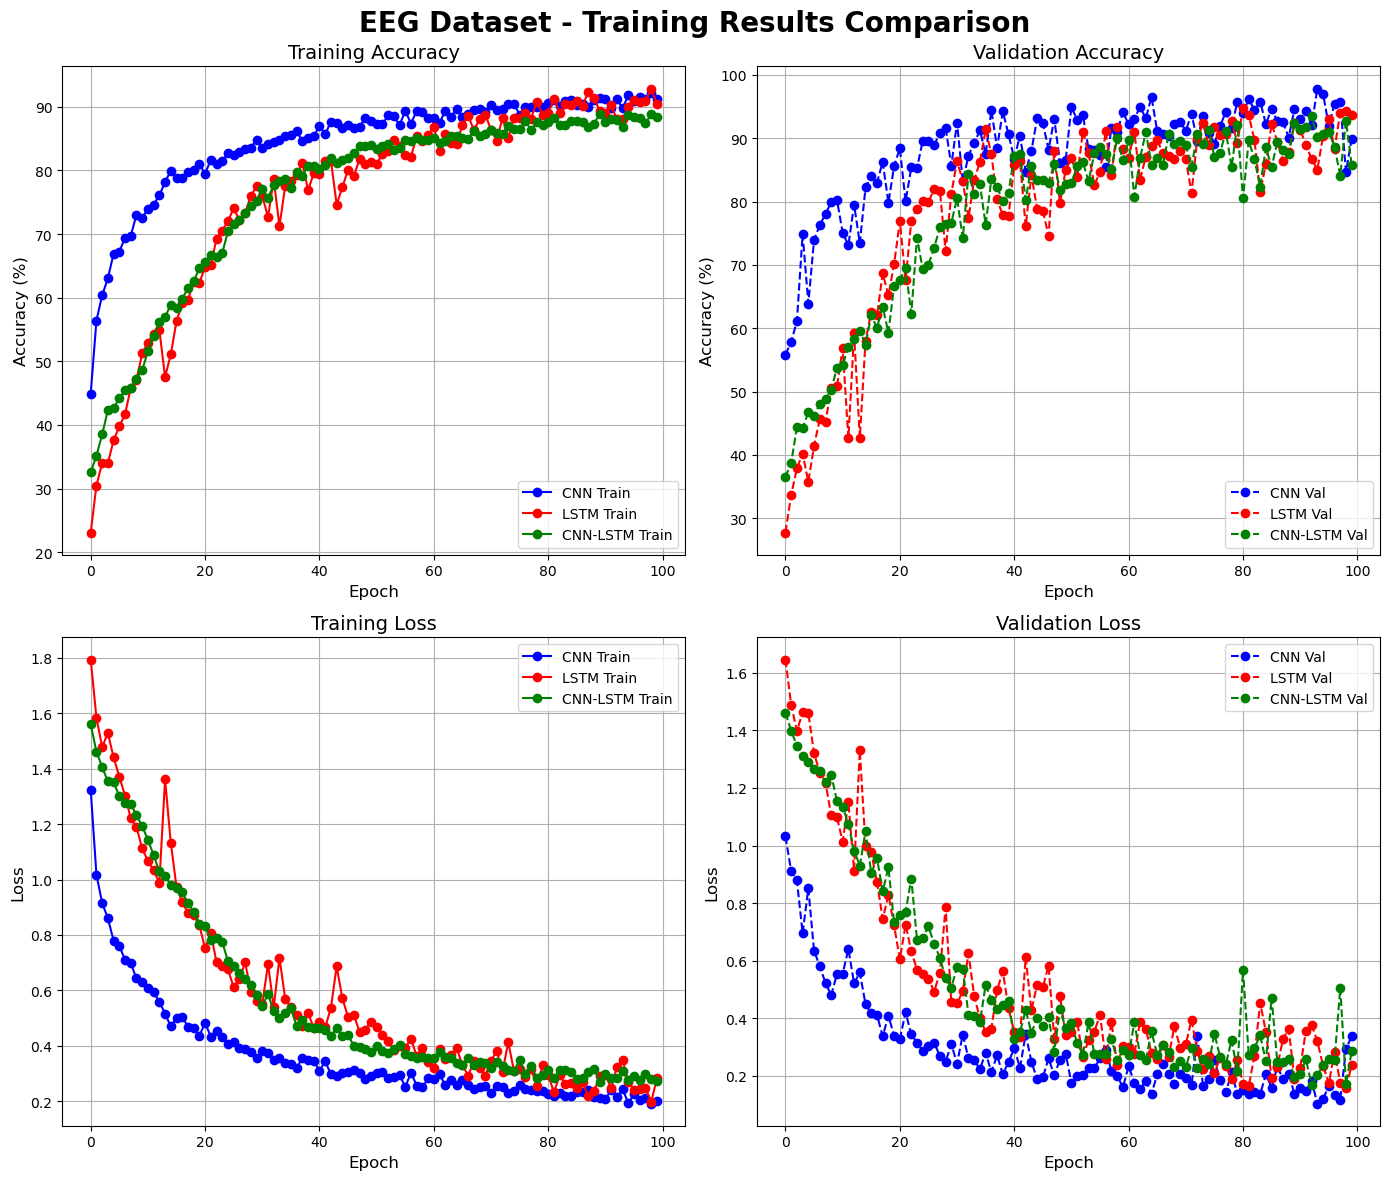

In [32]:
# Plot comparison of all models
print_color("\nPlotting model comparison...", "blue")
plot_model_comparison(all_metrics)
